# Predicting House Prices Using Machine Learning

In this Project a dataset of previously sold houses will be analyzed. A linear regression machine learning model will be trained and tested on its ability to predict sale prices.

The [dataset](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) is made up of data on houses sold in Ames, Iowa in the years between from 2006 to 2010. The dataset contains many features describing important attributes of every one of the houses sold.

## Setup

In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

In [2]:
# load the data into a Pandas DataFrame
data = pd.read_csv('AmesHousing.tsv', delimiter= '\t')

In [3]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Feature engineering:

Now a number of features will be prepared for use by the machine learning model. This is a very important step in any machine learning project, because using poorly suited features can greatly reduce the accuracy of any machine learning model. This is especially important for linear regression models because they are very limited and very dependent on well selected and engineered features, because for them to be accurate, the features have to have a linear relation to the target value.

The first step in feature engineering will be to add two columns that describe the age a building was sold or remodeled at. This should hopefully be more useful to a linear regression model than using the year. If two houses were compared, one remodeled in 2010 and one in 1950, these two dates would have a very small impact on a linear regression model even though their remodel was 60 years apart.

In [4]:
age_sold = data['Yr Sold'] - data['Year Built']
age_remod = data['Year Remod/Add'] - data['Year Built']

data['age_sold'] = age_sold
data['age_remod'] = age_remod

`transform_features()`:

This function's goal is to select and engineer the features for the linear regression model:

1. Dropping all columns with more than a given amount of NaN values (currently 5%).
2. replacing the values in columns with between 0 & 5% NaN values with the mode for that column.

Eliminating all NaN values is very important, because machine learning models cannot make predictions on them. `scikit learn`, the model used to train and test the model will throw errors if the user tries to fit a model on a dataset containing NaN values, but using them in general can lead to faulty and inaccurate models, that behave in unexpected ways.

3. Certain columns are dropped by name directly, as they don't contribute useful information or are otherwise not useful for machine learning. These are also columns that can leak the sale price without providing information about the building itself. They can be found in the list `drop_cols`

Columns that are unsuited for machine learning models and in this case ones that do not have a linear relation to the target column can reduce the accuracy of a machine learning model, since they are also taken into consideration when making predictions, thus reducing the impact of the well-suited models on the resulting prediction.

Columns, that contain direct information about the target column would not be available in a scenario where the model is used to make predictions on unknown sets of data, which is the primary use for machine learning models

In [5]:
def transform_features(df):
    '''Engineer and select features for use by a linear regression model
    Args:
        df (pandas.DataFrame): DataFrame containing features
    Returns:
        pandas.DataFrame with a select number of improved features
    '''
    drop_cols = ['Year Built', 'Yr Sold', 'Year Remod/Add',
                 'Mo Sold', 'banana', 'Order', 'PID',
                 "Sale Condition", "Sale Type", 'Garage Cars']
    missing_vals = df.isnull().sum()/df.shape[0]
    high_na_cols = df.columns[missing_vals > 0.05]
    df = df.drop(columns = high_na_cols)
#     sale_cols = df.columns[df.columns.str.contains('sold', flags = re.I)]
#     df = df.drop(columns = sale_cols)
    
    # dropping columns by name
    for column in drop_cols:
        if column in df.columns:
            df = df.drop(columns = column)
        else:
            print('column {} not in dataframe'.format(column))

    missing_vals = df.isnull().sum()/df.shape[0]
    low_na_num = ((df[missing_vals[(missing_vals > 0) & (missing_vals < 0.05)].index])
                  .select_dtypes(include = ['int64','float64']).columns)
    if low_na_num.shape[0] > 0:
        df[low_na_num] = df[low_na_num].fillna(df[low_na_num].mode().to_dict(orient='records')[0])
        
    return df

`select_features()`:

This function selects the columns from the DataFrame for use as features. This selection is based on two conditions:

1. The column must be of a numeric type
2. The column has to have a correlation value with the target value above a given threshold (0.4)

In [6]:
def select_features(df):
    '''Select features out of a dataframe
    Args:
        df (pandas.DataFrame): DataFrame to process
    Returns:
        pandas.DataFrame with only the selected columns
    '''
    numerical_df = df.select_dtypes(include = ['int','float'])
    corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > 0.4]

    return data[numerical_df[corr_cols]]

`train_and_test()`:

This function automatically trains and tests a linear regression model.
The function:

1. divides the dataset into a training function and a test set
2. calls the `select_features()` function to get cleaned data from the sets
3. instantiates, trains and tests a machine learning model using the linear regression model and the scikit learn module.It tests the accuracy of the model by calculating the root mean squared error when comparing the model's prediction of the `SalePrice` of the house to the value in the test set.

In [7]:
def train_and_test(df):
    '''Train and test a linear regression model
    Args:
        df (pandas.DataFrame): DataFrame to train and test the model on
    Returns:
        float: The root mean squared error of the model
    '''
    # divide the data in a train and test set
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    # extract features to use and use only the numerical columns
    features = train
    num_cols = features.select_dtypes(include = ['float','int']).drop(columns = ['SalePrice'])
    
    # instantiating, training and testing the machine_learning model
    lr = LinearRegression()
    lr.fit(num_cols, train.SalePrice)
    predictions = lr.predict(test[num_cols.columns])
    rmse = mean_squared_error(test.SalePrice, predictions)**0.5
    return rmse

## Feature Selection:

An important part of preparing data for use by the model is to select the best features. In this process, it is important to make sure the features selected do not contain redundant information, because this information would be used multiple times, biasing the model.

A correlation heatmap can be used to quickly identify some sources of redundant information, because these columns will correlate quite strongly with each other.

column banana not in dataframe


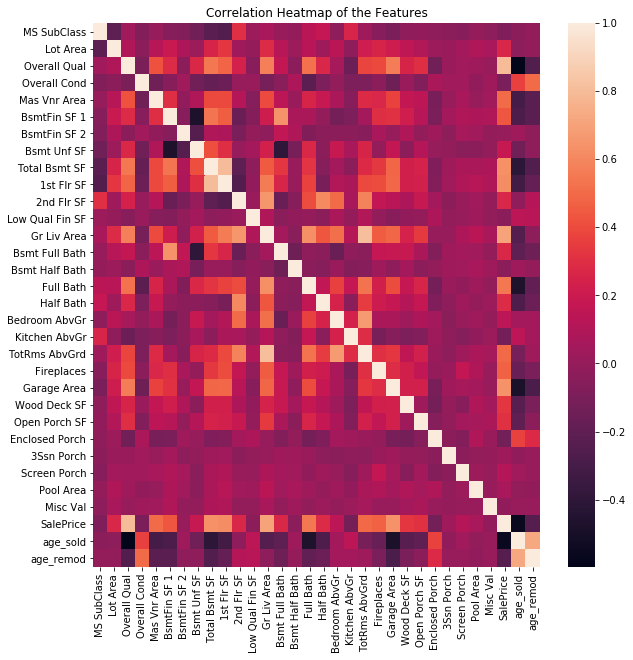

In [8]:
numerical_df = transform_features(data).select_dtypes(include = ['int64','float64'])

plt.figure(figsize = (10,10))
plt.title('Correlation Heatmap of the Features')
sns.heatmap(numerical_df.corr())

The graph above shows several groups of redundant information:

* `garage_cars` and `garage_area` are redundant. Since it is more granular and provides more information, `garage_area` will be used while `garage_cars` will be dropped. 

* With other correlations it is not clear if the information is redundant or important. For example, of course the area of the basement is very closely related to that of the ground floor, since the ground floor is built on top of the basement, but they both contribute to the total area of the house. So if one of them is dropped, they would contribute less than the other, higher floors.

## Feature selection: Target column:

Another important criterion for selecting columns is how strongly they correlate to the target column. This can give an idea of how valuable they might be to the model when making a prediction. A correlation value that is higher than expected can also reveal columns that contain direct information on the target column. This type of information would cause the model to perform unreasonably well and at the same time cause it to not be applicable to new data, where the target column as well as all columns directly containing information on the target value would not be available.

Now all columns with an absolute correlation value of less than 0.4 will be removed.

In [9]:
corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > 0.4]

In [10]:
numerical_df[corr_cols].head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Area,SalePrice,age_sold
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,528.0,215000,50
1,5,0.0,468.0,882.0,896,896,1,5,0,730.0,105000,49
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,312.0,172000,52
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,522.0,244000,42
4,5,0.0,791.0,928.0,928,1629,2,6,1,482.0,189900,13


In [11]:
corr_cols

Index(['Overall Qual', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
       '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Area', 'SalePrice', 'age_sold'],
      dtype='object')

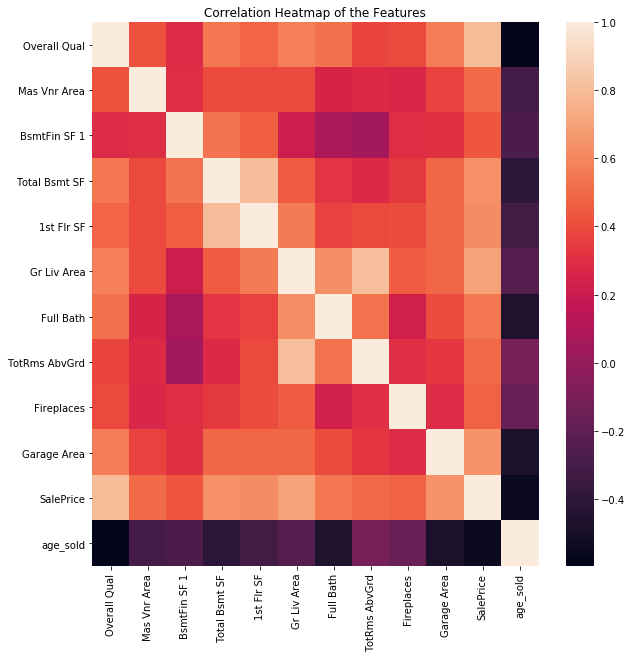

In [12]:
plt.figure(figsize = (10,10))
plt.title('Correlation Heatmap of the Features')
sns.heatmap(numerical_df[corr_cols].corr())

## Analysis

None of the remaining columns have any direct information about the target column, `SalePrice`. All of them could be used when training the model.

## Updated functions:

In [13]:
def transform_features(df = data):
    '''Engineer and select features for use by a linear regression model
    Args:
        df = data (pandas.DataFrame): DataFrame containing features
    Returns:
        pandas.DataFrame with a select number of improved features
    '''
    drop_cols = ['Year Built', 'Yr Sold', 'Year Remod/Add',
                 'Mo Sold', 'banana', 'Order', 'PID',
                 "Sale Condition", "Sale Type", 'Garage Cars', 'Alley']
    missing_vals = df.isnull().sum()/df.shape[0]
    high_na_cols = df.columns[missing_vals > 0.05]
    df = df.drop(columns = high_na_cols)
    for column in drop_cols:
        if column in df.columns:
            df = df.drop(columns = column)
        else:
            print('column {} not in dataframe'.format(column))
    missing_vals = df.isnull().sum()/df.shape[0]
    low_na_num = ((df[missing_vals[(missing_vals > 0) & (missing_vals < 0.05)].index])
                  .select_dtypes(include = ['int64','float64']).columns)
    if low_na_num.shape[0] > 0:
        df[low_na_num] = df[low_na_num].fillna(df[low_na_num].mode().to_dict(orient='records')[0])
        
    return df

def select_features(df = transform_features()):
    '''Select features out of a dataframe
    Args:
        df = transform_features() (pandas.DataFrame): DataFrame to process
    Returns:
        pandas.DataFrame with only the selected columns
    '''
    numerical_df = df.select_dtypes(include = ['int64','float64'])
    corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > 0.4]

    return numerical_df[corr_cols]

def train_and_test(df = select_features()):
    '''Train and test a linear regression model
    Args:
        df = select_features() (pandas.DataFrame): DataFrame to train and test the model on
    Returns:
        float: The root mean squared error of the model'''
    # divide the data in a train and test set
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    # extract features to use and use only the numerical columns
    features = train
    num_cols = features.select_dtypes(include = ['float64','int64']).drop(columns = ['SalePrice'])
    
    # instantiating, training and testing the machine_learning model
    lr = LinearRegression()
    lr.fit(num_cols, train.SalePrice)
    predictions = lr.predict(test[num_cols.columns])
    rmse = mean_squared_error(test.SalePrice, predictions)**0.5
    return rmse

column banana not in dataframe
column Alley not in dataframe


In [14]:
data['Roof Style'].value_counts()

Gable      2321
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: Roof Style, dtype: int64

## Columns for categorization

So far only numerical features were used, but it is possible to use other features in a linear regression model as well.

Some of the other aspects in the dataset what is called nominal or categorical variables. These put the house in a certain category. One example of this is the column `Roof Type`. It has information about the type of roof a house has, such as "flat" or "Gable. Columns like this can be transformed to be used in training a linear regression model, which only uses numerical values. Many of the different attributes can often not be ordered compared to how much they will influence the target value. For example at this point it is not clear whether a flat roof makes a house more expensive than a gable roof. If this were known, it would be possible to try to order them and assign numerical values to them. But even if this is possible the linear regression model requires that the features have a linear relation to the target variable. To get around this, it is best to make a column for each possible category in a nominal feature and assign each house either a 1 or a 0 depending on if a category applies to the house or not, respectively.

The nominal columns in the dataframe are:

In [15]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

Only nominal features that have 10 or less unique values will be used to avoid the dataset from becoming too large and the model to be too biased by a single attribute.

In [16]:
cat_cols = []
for column in nominal_features:
    uniques = data[column].unique().shape[0]
    print(column, uniques)
    if uniques <= 10:
        cat_cols.append(column)

PID 2930
MS SubClass 16
MS Zoning 7
Street 2
Alley 3
Land Contour 4
Lot Config 5
Neighborhood 28
Condition 1 9
Condition 2 8
Bldg Type 5
House Style 8
Roof Style 6
Roof Matl 8
Exterior 1st 16
Exterior 2nd 17
Mas Vnr Type 6
Foundation 6
Heating 6
Central Air 2
Garage Type 7
Misc Feature 6
Sale Type 10
Sale Condition 6


The new columns need to be checked for NaN values as well:

In [17]:
data[cat_cols].isnull().sum()

MS Zoning            0
Street               0
Alley             2732
Land Contour         0
Lot Config           0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Roof Style           0
Roof Matl            0
Mas Vnr Type        23
Foundation           0
Heating              0
Central Air          0
Garage Type        157
Misc Feature      2824
Sale Type            0
Sale Condition       0
dtype: int64

`Mas Vnr Type` has 23 nan values. We can replace those with 'none'.

In [18]:
data['Mas Vnr Type'].value_counts(dropna = False)

None       1752
BrkFace     880
Stone       249
BrkCmn       25
NaN          23
CBlock        1
Name: Mas Vnr Type, dtype: int64

`Garage Type`:

In [19]:
data['Garage Type'].value_counts(dropna = False)

Attchd     1731
Detchd      782
BuiltIn     186
NaN         157
Basment      36
2Types       23
CarPort      15
Name: Garage Type, dtype: int64

This column has 157 nan values. Which probably just means that those houses have no garages. So they can again be replaced with 'none'

In [20]:
df = data.copy()

for column in ['Garage Type', 'Mas Vnr Type']:
    if column in df.columns:
        print(df[column].isnull().sum())
        df[column] = df[column].fillna('none')
        print(df[column].isnull().sum())

157
0
23
0


The other columns with nan values will be dropped by the functions because of the large ammount of NaN values. But this can also be done manually:

In [21]:
for column in ['Misc Feature', 'Alley']:
    if column in cat_cols:
        cat_cols.remove(column)

Now the remaining functions will be turned into the categorical type. This causes all of the unique values in a nominal feature to be assigned a number and then the values in the column to be replaced by these numbers.

Next for each of the possible categories a new column is created and each of the houses is assigned either a 1 or a 0 depending on if the category applies to the house.

In the final step these new dummy columns are appended to the end of the DataFrame and the original columns dropped.

This will allow the model to use these features when training and predicting.

In [22]:
for column in cat_cols:
    df[column] = df[column].astype('category')
df = pd.concat([df,pd.get_dummies(df.select_dtypes(include = ['category']))], axis = 1)
df = df.drop(cat_cols, axis = 1)

Now the remaining columns and their correlation values relative to `SalePrice` are:

In [24]:
data.corr().SalePrice.abs().sort_values(ascending = False)

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
age_sold           0.558907
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID                0.246521
age_remod          0.240168
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch     0.128787
Kitchen AbvGr      0.119814
Screen Porch       0.112151
Overall Cond       0.101697
MS SubClass        0.085092
Pool Area          0.068403
Low Qual Fin SF    0.037660
Bsmt Half Bath     0.035835
Mo Sold            0

This functionality can now be included in the `transform_features()` and `select_features()` functions:

In [27]:
def transform_features(df = data,un_thresh = 10, nan_thresh = 0.05):
    '''Engineer and select features for use by a linear regression model
    Args:
        df = data (pandas.DataFrame): DataFrame containing features
        un_thresh = 10 (int) : threshold of maximum unique values in a categorical column to include
        nan_thresh = 0.05 (float): Threshold of proportion of nan values in column to include
    Returns:
        pandas.DataFrame with a select number of improved features
    '''
    drop_cols = ['Year Built', 'Yr Sold', 'Year Remod/Add',
                 'Mo Sold', 'banana', 'Order', 'PID',
                 "Sale Condition", "Sale Type", 'Garage Cars', 'Alley']
    missing_vals = df.isnull().sum()/df.shape[0]
    high_na_cols = df.columns[missing_vals > nan_thresh]
    df = df.drop(columns = high_na_cols)
    # Turning the nominal columns into categorical dummies:
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    # making the column list for the categorization
    cat_cols = []
    for column in nominal_features:
        if column in df.columns:
            uniques = data[column].unique().shape[0]
            if uniques < un_thresh:
                cat_cols.append(column)
                
    # replacing the nan values in the two columns that have few
    for column in ['Garage Type', 'Mas Vnr Type']:
        if column in df.columns:
            df[column] = df[column].fillna('none')
        
    # finally making the dummy columns and concatenating them to df
    for column in cat_cols:
        df[column] = df[column].astype('category')
    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include = ['category']))], axis = 1)
    df = df.drop(cat_cols, axis = 1)
    
    # dropping certain columns by name
    for column in drop_cols:
        if column in df.columns:
            df = df.drop(columns = column)
        else:
            print('column {} not in dataframe'.format(column))
    missing_vals = df.isnull().sum()/df.shape[0]
    low_na_num = ((df[missing_vals[(missing_vals > 0) & (missing_vals < 0.05)].index])
                  .select_dtypes(include = ['int64','float64']).columns)
    if low_na_num.shape[0] > 0:
        df[low_na_num] = df[low_na_num].fillna(df[low_na_num].mode().to_dict(orient='records')[0])
    print(df.shape)
    return df

def select_features(df = transform_features(),corr_thresh = 0.4):
    '''Select features out of a dataframe
    Args:
        df (pandas.DataFrame): DataFrame to process
        corr_thresh = 0.4 (float): threshold of correlation value to include column
    Returns:
        pandas.DataFrame with only the selected columns
    '''
    numerical_df = df.select_dtypes(include = ['int64','float64'])
    corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > corr_thresh]

    return numerical_df[corr_cols]

def train_and_test(df = select_features()):
    '''Train and test a linear regression model
    Args:
        df (pandas.DataFrame): DataFrame to train and test the model on
    Returns:
        float: The root mean squared error of the model'''
    # divide the data in a train and test set
    sp = df.SalePrice
    df.drop(columns = 'SalePrice',inplace = True)
    df = (df - df.min()) /(df.max() - df.min())
    df = pd.concat([df,sp], axis =1)
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    # extract features to use and use only the numerical columns
    features = train
    num_cols = features.select_dtypes(include = ['float64','int64']).drop(columns = ['SalePrice'])
    
    # instantiating, training and testing the machine_learning model
    lr = LinearRegression()
    lr.fit(num_cols, train.SalePrice)
    predictions = lr.predict(test[num_cols.columns])
    rmse = mean_squared_error(test.SalePrice, predictions)**0.5
    return rmse

column banana not in dataframe
column Sale Condition not in dataframe
column Alley not in dataframe
(2930, 138)


In [22]:
train_and_test()

40838.476842105505

Now to make a more refined way of testing the model:
We will add a new parameter k:
* if k == 0, the function will use the current selection process:
    1. splitting the dataframe at 1460
    2. training on the train set
    3. testing on the test set and calculating the rmse
* if k==1 the function will do a cross validation:
    1. Shuffle the rows
    2. assign the first 1460 rows to a variable called `fold_one`
    3. assign the rest to `fold_two`
    4. train on `fold_one`, test on `fold_two`
    5. train on `fold_two`, test on `fold_one`
    6. calculate the average rmse
   

In [28]:
np.random.seed(1)
df = transform_features(data)
df = select_features(df)

#randomizing the dataset's rows
shuffled_index = np.random.permutation(df.shape[0])
df = df.iloc[shuffled_index].reset_index().drop('index', axis = 1)

# making the two training sets
fold_one = df.iloc[:1460].copy()
fold_two = df.iloc[1460:].copy()
fold_one_sp = fold_one.SalePrice.copy()
fold_one.drop(columns = 'SalePrice', inplace = True)
fold_two_sp = fold_two.SalePrice.copy()
fold_two.drop(columns = 'SalePrice', inplace = True)

#training models and calculating the rmses
lr = LinearRegression()

lr.fit(fold_one, fold_one_sp)
predicts_f_1 = lr.predict(fold_two)
rmse1 = mean_squared_error(fold_two_sp, predicts_f_1)**0.5

lr.fit(fold_two, fold_two_sp)
predicts_f_2 = lr.predict(fold_one)
rmse2 = mean_squared_error(fold_one_sp, predicts_f_2)**0.5
print((rmse1+rmse2)/2)

column banana not in dataframe
column Sale Condition not in dataframe
column Alley not in dataframe
(2930, 138)
35181.29274302898


Now to add this functionality to `train_test()`:

In [32]:
def transform_features(df = data,un_thresh = 10, nan_thresh = 0.05):
    '''Engineer and select features for use by a linear regression model
    Args:
        df = data (pandas.DataFrame): DataFrame containing features
        un_thresh = 10 (int) : threshold of maximum unique values in a categorical column to include
        nan_thresh = 0.05 (float): Threshold of proportion of nan values in column to include
    Returns:
        pandas.DataFrame with a select number of improved features
    '''
    drop_cols = ['Year Built', 'Yr Sold', 'Year Remod/Add',
                 'Mo Sold', 'banana', 'Order', 'PID',
                 "Sale Condition", "Sale Type", 'Garage Cars', 'Alley']
    missing_vals = df.isnull().sum()/df.shape[0]
    high_na_cols = df.columns[missing_vals > nan_thresh]
    df = df.drop(columns = high_na_cols)
    # Turning the nominal columns into categorical dummies:
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    # making the column list for the categorization
    cat_cols = []
    for column in nominal_features:
        if column in df.columns:
            uniques = data[column].unique().shape[0]
            if uniques < un_thresh:
                cat_cols.append(column)
                
    # replacing the nan values in the two columns that have few
    for column in ['Garage Type', 'Mas Vnr Type']:
        if column in df.columns:
            df[column] = df[column].fillna('none')
        
    # finally making the dummy columns and concatenating them to df
    for column in cat_cols:
        df[column] = df[column].astype('category')
    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include = ['category']))], axis = 1)
    df = df.drop(cat_cols, axis = 1)
    
    # dropping certain columns by name
    for column in drop_cols:
        if column in df.columns:
            df = df.drop(columns = column)
        else:
            print('column {} not in dataframe'.format(column))
    missing_vals = df.isnull().sum()/df.shape[0]
    low_na_num = ((df[missing_vals[(missing_vals > 0) & (missing_vals < 0.05)].index])
                  .select_dtypes(include = ['int64','float64']).columns)
    if low_na_num.shape[0] > 0:
        df[low_na_num] = df[low_na_num].fillna(df[low_na_num].mode().to_dict(orient='records')[0])
    print(df.shape)
    return df

def select_features(df = transform_features(),corr_thresh = 0.4):
    '''Select features out of a dataframe
    Args:
        df (pandas.DataFrame): DataFrame to process
        corr_thresh = 0.4 (float): threshold of correlation value to include column
    Returns:
        pandas.DataFrame with only the selected columns
    '''
    numerical_df = df.select_dtypes(include = ['int64','float64'])
    corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > corr_thresh]

    return numerical_df[corr_cols]

def train_and_test(df = select_features(), k = 0):
    '''Train and test a linear regression model
    Args:
        df (pandas.DataFrame): DataFrame to train and test the model on
        k = 0 (int: 0 or 1): select the mode to use for testing:
            0: split the dataset into train and test set at the midpoint
            1: Use a cross validation containing two folds
    Returns:
        float: The root mean squared error of the model'''
    if k == 0:
        # divide the data in a train and test set
        sp = df.SalePrice
        df.drop(columns = 'SalePrice',inplace = True)
        df = (df - df.min()) /(df.max() - df.min())
        df = pd.concat([df,sp], axis =1)
        train = df.iloc[:1460]
        test = df.iloc[1460:]
    
        # extract features to use and use only the numerical columns
        features = train
        num_cols = features.select_dtypes(include = ['float64','int64']).drop(columns = ['SalePrice'])
    
        # instantiating, training and testing the machine_learning model
        lr = LinearRegression()
        lr.fit(num_cols, train.SalePrice)
        predictions = lr.predict(test[num_cols.columns])
        rmse = mean_squared_error(test.SalePrice, predictions)**0.5
        return rmse
    if k == 1:
        np.random.seed(1)

        #randomizing the dataset's rows
        shuffled_index = np.random.permutation(df.shape[0])
        df = df.iloc[shuffled_index].reset_index().drop('index', axis = 1)

        # making the two training sets
        fold_one = df.iloc[:1460].copy()
        fold_two = df.iloc[1460:].copy()
        fold_one_sp = fold_one.SalePrice.copy()
        fold_one.drop(columns = 'SalePrice', inplace = True)
        fold_two_sp = fold_two.SalePrice.copy()
        fold_two.drop(columns = 'SalePrice', inplace = True)

        #training models and calculating the rmses
        lr = LinearRegression()

        lr.fit(fold_one, fold_one_sp)
        predicts_f_1 = lr.predict(fold_two)
        rmse1 = mean_squared_error(fold_two_sp, predicts_f_1)**0.5

        lr.fit(fold_two, fold_two_sp)
        predicts_f_2 = lr.predict(fold_one)
        rmse2 = mean_squared_error(fold_one_sp, predicts_f_2)**0.5
        return (rmse1+rmse2)/2        

column banana not in dataframe
column Sale Condition not in dataframe
column Alley not in dataframe
(2930, 138)


In [33]:
train_and_test(k = 1)

35181.29274302898

## Results

The linear regression model shows a root mean squared uncertainty of 35000 USD when predicting the sale of the houses in the dataset.

# Summary

In this project a linear regression model was constructed to predict the prices of houses given some of their attributes. To achieve the most accurate result, the most promising columns in the dataset were selected and then engineered to be best suited to the linear regression model. In the end, the model achieved a root mean squared uncertainty of about 35,000 USD. This could possibly be improved by further feature engineering or by selecting a different, more powerful model, as in a lot of cases the linear regression model is a very limited one.